In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd
import warnings
from sklearn.neighbors import BallTree
import lightgbm as lgb
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

# Display all columns
pd.set_option('display.max_columns', None)
input_path = '../input/'
gdf_land = gpd.read_file(os.path.join(input_path, 'L02-25.geojson'))
df_land = gdf_land.copy()
df_land['price'] = df_land['L02_006']
df = pd.read_csv(os.path.join(input_path, 'train.csv'))
test = pd.read_csv(os.path.join(input_path, 'test.csv'))
gdf_land.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21431 entries, 0 to 21430
Columns: 140 entries, L02_001 to geometry
dtypes: float64(4), geometry(1), int32(69), object(66)
memory usage: 17.2+ MB


In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree

def preprocess_data(input_df, df_land, is_train=True):
    """
    駅情報は一旦無視！
    「巨大なゴミデータ」の削除と、「地価・築年数」だけに集中したシンプル版
    """
    df = input_df.copy()
    
    # -----------------------------------------------------
    # 0. 【Trainのみ】ハズレ値などの削除
    # -----------------------------------------------------
    if is_train:
        # 1. 面積フィルタ
        # 面積500㎡以上はカット
        df = df[df['unit_area'] < 500] 
        
        # 2. 単価がおかしい土地を削除
        # 単価(円/㎡)を計算
        temp_unit_price = df['money_room'] / df['unit_area']
        
        # 「単価が1万円/㎡ 以下」は、原野や山林なので捨てる
        df = df[temp_unit_price > 10000] 
        
        # 3. 「高すぎる単価」もノイズになるのでキャップを設ける
        df = df[temp_unit_price < 10000000]

    # -----------------------------------------------------
    # 1. 駅情報 (今後実装予定)
    # -----------------------------------------------------
    pass

    # -----------------------------------------------------
    # 2. 築年数の計算 
    # -----------------------------------------------------
    df['year_built'] = pd.to_numeric(df['year_built'], errors='coerce')
    df['year_built'] = df['year_built'].fillna(df['year_built'].median())
    df['temp_time'] = pd.to_datetime(df['year_built'].astype(int).astype(str), format='%Y%m', errors='coerce')
    
    base_date = pd.to_datetime('2025-12-01')
    df['building_month'] = (base_date - df['temp_time']).dt.days / 30.44
    df['building_month'] = df['building_month'].fillna(df['building_month'].median())
    df['building_month'] = df['building_month'].astype(float)

    # -----------------------------------------------------
    # 3. 地価データの結合 
    # -----------------------------------------------------
    if not df_land.empty:
        df_land['lat'] = df_land.geometry.y
        df_land['lon'] = df_land.geometry.x
        land_clean = df_land[['lat', 'lon', 'price']].dropna()
        
        # データがある場合のみBallTree
        if len(land_clean) > 0:
            land_rad = np.deg2rad(land_clean[['lat', 'lon']])
            input_rad = np.deg2rad(df[['lat', 'lon']])
            
            tree = BallTree(land_rad, metric='haversine')
            dists, indices = tree.query(input_rad, k=1)
            
            df['land_price'] = land_clean['price'].values[indices.flatten()]
            df['dist_to_land_price'] = dists.flatten() * 6371 * 1000
            df['log_land_price'] = np.log1p(df['land_price'])
        else:
             df['log_land_price'] = 0
             df['dist_to_land_price'] = 0
    else:
        df['log_land_price'] = 0
        df['dist_to_land_price'] = 0

    # 4. 地価フィルタ (Trainのみ)
    # 正しい地価データが入っていれば有効化
    if is_train and 'log_land_price' in df.columns:
         df = df[df['log_land_price'] > 5] 

    # -----------------------------------------------------
    # 5. 特徴量リスト
    # -----------------------------------------------------
    cat_cols = ['addr1_2', 'layout', 'direction', 'structure']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).fillna('unknown').astype('category')
            
    # 数値特徴量からも station_minutes を削除
    num_features = ['unit_area', 'log_land_price', 'dist_to_land_price', 'building_month']
    features = num_features + [c for c in cat_cols if c in df.columns]

    target = None
    if is_train:
        # 単価計算
        unit_price = df['money_room'] / df['unit_area']
        target = np.log1p(unit_price)

    return df, features, target

In [3]:
# ---------------------------------------------------------
# 1. 前処理 (Train & Test)
# ---------------------------------------------------------
print("前処理を実行中...")

# Trainデータの処理 (学習用なので is_train=True)
# ※ preprocess_data関数はさっき定義した最新版を使ってください
train_processed, features, target_log = preprocess_data(df, df_land, is_train=True)
# 【Train独自の処理】
# 面積がないデータは「教師として質が悪い」ので、行ごと消す
train_processed = train_processed.dropna(subset=['unit_area'])

# 削除した分、target（目的変数）も合わせる必要があるので、再計算するか
# あるいは preprocess_data の中で dropna してから target を作るのが安全ですが、
# 今の段階なら「埋めるための値（中央値）」をここで計算して保存しておくのが大事です。

# ★Testを埋めるための「正解の値」をキープ！
fill_value = train_processed['unit_area'].median() 


# ---------------------------------------------------------
# 2. Testデータの処理
# ---------------------------------------------------------
# 先に関数を通す
test_processed, _, _ = preprocess_data(test, df_land, is_train=False)

# 【Test独自の処理】
# 提出用なので行は消せない。「Trainの中央値」を使って埋める
test_processed['unit_area'] = test_processed['unit_area'].fillna(fill_value)
print(f"使用する特徴量: {len(features)}個")
print(features)

# ---------------------------------------------------------
# 2. モデル学習
# ---------------------------------------------------------
print("\nモデル学習中...")

# 検証用に分割 (提出前に手元のスコアを知るため)
X = train_processed[features]
y = target_log
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 学習実行
model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

# ---------------------------------------------------------
# 3. 予測 & 結果の復元
# ---------------------------------------------------------
print("予測を実行中...")

# テストデータに対して予測 (結果は対数単価)
pred_log = model.predict(test_processed[features])

# 【重要】対数を戻す (log -> exp)
pred_price_per_m2 = np.expm1(pred_log)

# 【重要】単価を総額に戻す (単価 × 面積)
# ※ 提出は「総額」のはずなので、必ず面積を掛けます
pred_total_price = pred_price_per_m2 * test_processed['unit_area']

# ---------------------------------------------------------
# 4. 提出用CSVの作成
# ---------------------------------------------------------
print("CSV作成中...")

# id列と予測値をくっつける
submission = pd.DataFrame({
    'id': test['id'],         # テストデータのID
    'prediction': pred_total_price # 予測した総額
})

# CSVに書き出し (header=Falseが必要な場合が多いので注意)
# 今回は「id,値段」の形式ということなので、ヘッダーありかなしか確認してください。
# 多くの場合、SIGNATEなどはヘッダー不要(header=False)か、指定のヘッダー名が必要です。
# ここでは一旦、一般的な「ヘッダーなし」で保存します。
submission.to_csv('submission.csv', index=False, header=False)

print("\n完了！ 'submission.csv' が保存されました。")
print("先頭5行はこんな感じです↓")
print(submission.head())

前処理を実行中...


使用する特徴量: 5個
['unit_area', 'log_land_price', 'dist_to_land_price', 'building_month', 'addr1_2']

モデル学習中...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1146
[LightGBM] [Info] Number of data points in the train set: 253379, number of used features: 5
[LightGBM] [Info] Start training from score 12.476830
予測を実行中...
CSV作成中...

完了！ 'submission.csv' が保存されました。
先頭5行はこんな感じです↓
   id    prediction
0   0  1.369971e+07
1   1  3.427658e+07
2   2  1.071412e+07
3   3  2.933161e+07
4   4  1.432400e+07


In [4]:
print(f"もとのデータ数：{len(test)} 行、予測データ数：{len(submission)} 行")

もとのデータ数：112437 行、予測データ数：112437 行


In [5]:
print(submission.isnull().sum())

id            0
prediction    0
dtype: int64


特徴量: ['unit_area', 'log_land_price', 'dist_to_land_price', 'building_month', 'addr1_2']
--------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1146
[LightGBM] [Info] Number of data points in the train set: 253379, number of used features: 5
[LightGBM] [Info] Start training from score 12.476830


Fold 1 MAPE: 24.439 %
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1146
[LightGBM] [Info] Number of data points in the train set: 253379, number of used features: 5
[LightGBM] [Info] Start training from score 12.475946
Fold 2 MAPE: 24.558 %
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1146
[LightGBM] [Info] Number of data points in the train set: 253379, number of used features: 5
[LightGBM] [Info] Start training from score 12.477778
Fold 3 MAPE: 24.431 %
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005774 seconds.
You can set `for

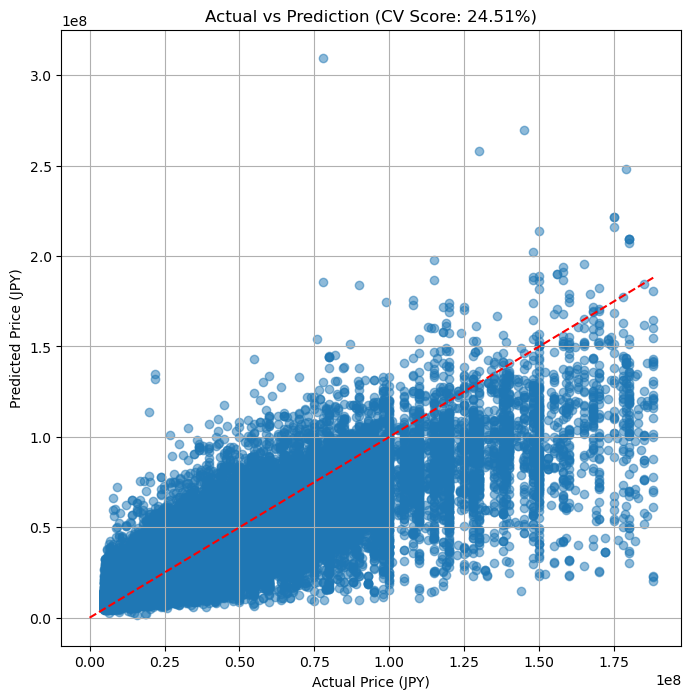

In [6]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# 0. データの準備 (前処理済みのものを使う)
# ---------------------------------------------------------
# df_train_processed, features, target_log = preprocess_data(train_df, gdf_land, is_train=True)

X = train_processed[features]
y = target_log # log1p(単価)

# ---------------------------------------------------------
# 1. K-Fold CV の設定
# ---------------------------------------------------------
n_splits = 5 # 5分割が一般的
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# 結果を保存する箱
oof_preds_log = np.zeros(len(X)) # 全データの予測値（対数）をここに集める
models = [] # 作った5つのモデルを保存しておく（後で平均したりする用）
scores = [] # 各Foldのスコア

# ---------------------------------------------------------
# 2. 交差検証ループ (5回まわす)
# ---------------------------------------------------------
print(f"特徴量: {features}")
print("-" * 50)

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    # 分割
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]
    
    # モデル定義 & 学習
    model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)] # 改善なければ早めに止める
    )
    
    # 予測 (対数)
    val_pred_log = model.predict(X_valid)
    
    # OOF配列に保存 (あとでまとめて評価するため)
    oof_preds_log[valid_idx] = val_pred_log
    
    # --- 評価 (このFold単体のMAPEを計算) ---
    # 1. 対数を戻す
    val_pred_price = np.expm1(val_pred_log)
    y_valid_price = np.expm1(y_valid)
    
    # 2. 単価 × 面積 ＝ 総額 に戻す
    # ※ iloc[valid_idx] で対応する行の面積を取ってくる
    val_pred_total = val_pred_price * train_processed.iloc[valid_idx]['unit_area']
    y_valid_total = y_valid_price * train_processed.iloc[valid_idx]['unit_area']
    
    # 3. MAPE計算
    score = np.mean(np.abs((y_valid_total - val_pred_total) / y_valid_total)) * 100
    scores.append(score)
    models.append(model)
    
    print(f"Fold {fold+1} MAPE: {score:.3f} %")

# ---------------------------------------------------------
# 3. 最終結果の確認
# ---------------------------------------------------------
print("-" * 50)
print(f"平均 MAPE: {np.mean(scores):.3f} %")
print("-" * 50)

# ---------------------------------------------------------
# 4. (オマケ) どこで外しているかグラフ化
# ---------------------------------------------------------
# 全体の予測値（総額）
oof_total_pred = np.expm1(oof_preds_log) * train_processed['unit_area']
actual_total = np.expm1(y) * train_processed['unit_area']

plt.figure(figsize=(8, 8))
plt.scatter(actual_total, oof_total_pred, alpha=0.5)
plt.plot([0, actual_total.max()], [0, actual_total.max()], 'r--', label='Perfect')
plt.xlabel('Actual Price (JPY)')
plt.ylabel('Predicted Price (JPY)')
plt.title(f'Actual vs Prediction (CV Score: {np.mean(scores):.2f}%)')
plt.grid(True)
plt.show()